## Dataset

In [6]:
%%capture


%pip install datasets

In [7]:
import matplotlib.pyplot as plt
from datasets import load_dataset


train = load_dataset('csv', data_files="/content/drive/MyDrive/Outros/Colab Notebooks/30 Days Of Bert/Day01/train (2).csv")
test = load_dataset('csv', data_files="/content/drive/MyDrive/Outros/Colab Notebooks/30 Days Of Bert/Day01/test (4).csv")

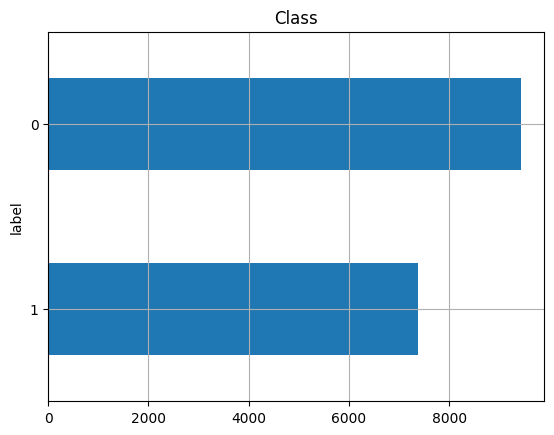

In [8]:
def conver2pandas(data):
    data.set_format(type="pandas")
    df = data["train"][:]

    return df


dfpd = conver2pandas(train)
dfpd["label"].value_counts(ascending=True).plot.barh()

plt.title("Class")
plt.grid(True)
plt.show()

In [9]:
n_classes = len(dfpd["label"].value_counts())
n_classes

2

In [10]:
lnames = dfpd['label'].unique()
lnames

array([0, 1])

In [11]:
train.reset_format()

## Model

In [12]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_train = train.map(tokenize_function, batched=True)
tokenized_test = test.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/16800 [00:00<?, ? examples/s]

Map:   0%|          | 0/4200 [00:00<?, ? examples/s]

In [13]:
small_train_dataset = tokenized_train["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_test["train"].shuffle(seed=42).select(range(1000))

In [14]:
small_train_dataset, small_eval_dataset

(Dataset({
     features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 1000
 }),
 Dataset({
     features: ['id', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 1000
 }))

## Train

In [15]:
from transformers import AutoModelForSequenceClassification


model = AutoModelForSequenceClassification.from_pretrained(
    "google-bert/bert-base-cased",
    num_labels=n_classes,
    torch_dtype="auto"
    )

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
%%capture


%pip install evaluate

In [17]:
import numpy as np
import evaluate


metric = evaluate.load("accuracy")

In [18]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [45]:
from transformers import TrainingArguments


training_args = TrainingArguments(
    output_dir="test_trainer",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    logging_steps=10,
    do_eval=True,
    eval_strategy="steps",


)

In [46]:
from transformers import TrainingArguments, Trainer


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [47]:
trainer.train()

Step,Training Loss,Validation Loss
10,0.000900,No log
20,0.826400,No log
30,0.629500,No log


KeyboardInterrupt: 

## Notes

Huh: Validation Loss -> No Log

* https://carloszan.medium.com/fine-tuning-em-um-modelo-bert-para-classifica%C3%A7%C3%A3o-de-dados-financeiros-com-hugging-face-13a80b421375

* [Trainer Class](https://huggingface.co/docs/transformers/main_classes/trainer)